# Distribution of clade durations in ARGs and detection of inversions

### Figures

---

In [1]:
import tskit
import msprime
import stdpopsim
import pyslim
import pickle
import numpy as np
import importlib
import math
import random
import copy

import matplotlib
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

import sys 
sys.path.append('..')
import argbd.branchdurations
import argbd.cladedurations
import argbd.viz

col_green = "#228833"
col_red = "#EE6677"
col_purp = "#AA3377"
col_blue = "#66CCEE"
col_yellow = "#CCBB44"
col_indigo = "#4477AA"
col_grey = "#BBBBBB"

trees_loc = '../../trees/'
results_loc = '../../results/'
fig_loc = '../../figures/'

# Simulation parameters
species = stdpopsim.get_species("HomSap")
chr21_contig = species.get_contig(chromosome='chr21', genetic_map="HapMapII_GRCh38")
chr21_mutation_rate = chr21_contig.mutation_rate
chr21_recombination_map = chr21_contig.recombination_map
None_contig = species.get_contig(length=5e6)
None_mutation_rate = None_contig.mutation_rate
None_recombination_map = None_contig.recombination_map
Ne = species.population_size

In [2]:
sim_chr21_100 = pickle.load(open(results_loc + "chr21/simulated_data_100_clades.results.pickle", "rb"))
tsdate_chr21_100 = pickle.load(open(results_loc + "chr21/tsdate_100_clades.results.pickle", "rb"))
relate_chr21_100 = pickle.load(open(results_loc + "chr21/relate_100_clades.results.pickle", "rb"))
argn_chr21_100 = pickle.load(open(results_loc + "chr21/argneedle_100_clades.results.pickle", "rb"))

---

# Example of running clade duration calculations

In [3]:
importlib.reload(argbd.cladedurations)
ts = tskit.load(trees_loc + "chr21/simulated_data_smc_prime_10.trees")
sim_chr21_10 = argbd.cladedurations.clade_duration(ts, Ne)
sim_chr21_10.calculate_q(chr21_recombination_map)

Computing tree variables: 100%|█████████████████████████████████████████████| 53445/53445 [00:02<00:00, 20632.12it/s]


Computing clade duration


100%|████████████████████████████████████████████████████████████████████████| 53445/53445 [00:16<00:00, 3144.07it/s]


55879 {}


## Figure 10 (left panel)

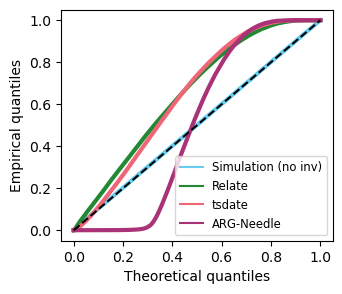

In [4]:
argbd.viz.qqplot(
    [sim_chr21_100, relate_chr21_100, tsdate_chr21_100, argn_chr21_100],
    legend_labels = ["Simulation (no inv)", "Relate", "tsdate", "ARG-Needle"],
    size = (3.5, 3),
    legend_font='small',
)

---

# SLiM inversion simulation

Simulated using SLiM script, then recapitating the trees using pyslim (i.e. simulating backwards to ensure every tree has one root) and selecting a sample of 100

Random seeds in SLiM: 1830346626823 (with inversion), 2651166003370 (neutral)

In [5]:
ts = tskit.load(trees_loc + "inversion/slim.trees")

Ne = 10000
demography = msprime.Demography.from_tree_sequence(ts)
for pop in demography.populations:
    pop.initial_size = 10000
recap = pyslim.recapitate(
    ts, 
    demography=demography,
    recombination_rate=1e-8, 
    random_seed=1,
)

seed = 98661
print("Random seed:", seed)
rng = np.random.default_rng(seed = seed)
alive_inds = pyslim.individuals_alive_at(recap, 0)
keep_indivs = rng.choice(alive_inds, 50, replace=False)
keep_nodes = []
for i in keep_indivs:
    keep_nodes.extend(recap.individual(i).nodes)

recap = recap.simplify(keep_nodes, keep_input_roots=False)
print("Inversion is above nodes:")
for m in recap.mutations():
    print(m.node)
print("="*10)
recap = msprime.sim_mutations(recap, rate=1e-8, random_seed=11, discrete_genome=True, keep=False)
print("Number of mutations:", recap.num_mutations)

ts_noinv = tskit.load(trees_loc + "inversion/slim_noinv.trees")
demography = msprime.Demography.from_tree_sequence(ts_noinv)
for pop in demography.populations:
    pop.initial_size = 10000
recap_noinv = pyslim.recapitate(
    ts_noinv, 
    demography=demography, 
    recombination_rate=1e-8, 
    random_seed=1,
)

alive_inds = pyslim.individuals_alive_at(recap_noinv, 0)
keep_indivs = rng.choice(alive_inds, 50, replace=False)
keep_nodes = []
for i in keep_indivs:
    keep_nodes.extend(recap_noinv.individual(i).nodes)

recap_noinv = recap_noinv.simplify(keep_nodes, keep_input_roots=False)
recap_noinv = msprime.sim_mutations(recap_noinv, rate=1e-8, random_seed=11, discrete_genome=True, keep=False)
print("Number of mutations:", recap_noinv.num_mutations)

/Users/ignatiev-admin/miniconda3/envs/p310/lib/python3.10/site-packages/msprime/ancestry.py:831: TimeUnitsMismatchWarning: The initial_state has time_units=ticks but time is measured in generations in msprime. This may lead to significant discrepancies between the timescales. If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
  warnings.warn(message, TimeUnitsMismatchWarning)


Random seed: 98661
Inversion is above nodes:
3536
3534
Number of mutations: 10148
Number of mutations: 10238


In [6]:
print(recap.num_samples, recap.sequence_length, recap.num_trees)
print(recap_noinv.num_samples, recap_noinv.sequence_length, recap_noinv.num_trees)

100 5000000.0 8492
100 5000000.0 8878


In [7]:
slim_recombination_map = msprime.RateMap(
    position=[0, recap.sequence_length],
    rate=[1e-8]
)

In [8]:
results_slim = argbd.cladedurations.clade_duration(recap, Ne, polytomies = True)
results_slim.calculate_q(slim_recombination_map)

Computing tree variables: 100%|█████████████████████████████████████████████████| 8492/8492 [00:14<00:00, 574.89it/s]


Computing clade duration


100%|████████████████████████████████████████████████████████████████████████████| 8492/8492 [07:50<00:00, 18.05it/s]


33248 {}


In [9]:
results_slim_noinv = argbd.cladedurations.clade_duration(recap_noinv, Ne, polytomies = True)
results_slim_noinv.calculate_q(slim_recombination_map)

Computing tree variables: 100%|█████████████████████████████████████████████████| 8878/8878 [00:16<00:00, 548.95it/s]


Computing clade duration


100%|████████████████████████████████████████████████████████████████████████████| 8878/8878 [08:20<00:00, 17.72it/s]


35057 {}


## Figure 10 (middle panel)

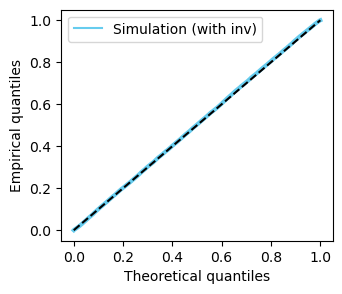

In [10]:
argbd.viz.qqplot(
    [results_slim],
    legend_labels = ["Simulation (with inv)"],
    size = (3.5, 3),
)

## Figure 10 (right panel)

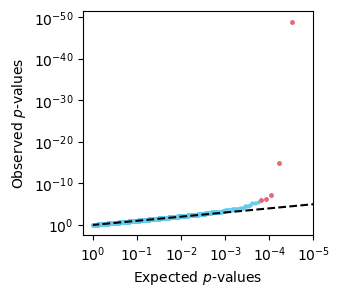

In [11]:
argbd.viz.outliers_plot(
    results_slim,
    outliers_threshold=0.05,
    size=(3.5, 3.07),
    xticks=[1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    yticks=[1, 1e-10, 1e-20, 1e-30, 1e-40, 1e-50],
)

## Figure A7

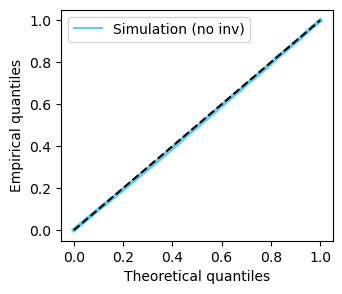

In [12]:
argbd.viz.qqplot(
    [results_slim_noinv],
    legend_labels = ["Simulation (no inv)"],
    size = (3.5, 3),
)

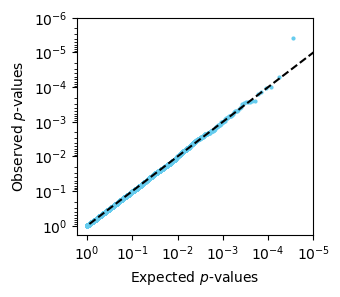

In [13]:
argbd.viz.outliers_plot(
    results_slim_noinv,
    outliers_threshold=0.05,
    size=(3.5, 3.07),
    xticks=[1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    yticks=[1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
)

## Figure 11

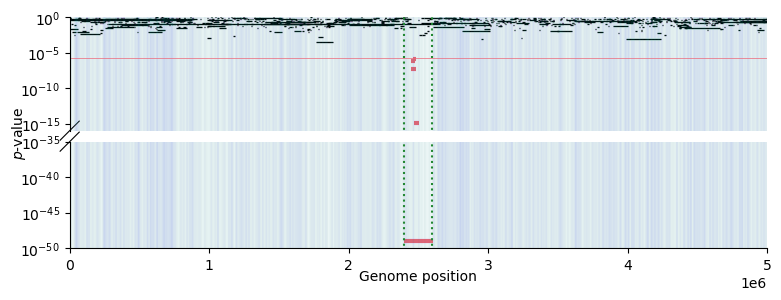

In [15]:
clades = results_slim
th = 0.05/clades.num
inds = [i for i in np.where(clades.sf < th)[0]]
rs = 44074  # random seed used for figure in paper
random.seed(rs)
clades_to_draw = set()
clades_to_draw.update({(clades.clades[i], "black", 1, i) for i in random.sample(range(clades.num), 2000)})
clades_to_draw.update({(clades.clades[i], col_red, 3, i) for i in inds})

plt.figure(figsize = (9,3))
bax = brokenaxes(ylims=((1e-50, 1e-35), (1e-16, 1)),
                 hspace=.1, yscale='log')
for j, (cl, col, w, i) in enumerate(clades_to_draw):
    bax.hlines(y = cl.sf,
               xmin = cl.start,
               xmax = cl.end,
               color=col,
               alpha = 1,
               lw = w,)
        
for t in recap.trees():
    bax.vlines(x = t.interval[1], ymin = 0, ymax = 1, color = col_blue, lw = 0.01, alpha = 1)
    
for s in [2400000, 2600000]:
    bax.vlines(x = s, ymin = 0, ymax = 1, color = col_green, ls=':')
    
bax.hlines(y=th, xmin = 0, xmax = recap.sequence_length, color=col_red, lw=0.5)
    
bax.set_xlim(0, recap.sequence_length)
bax.set_yscale("log")
bax.axs[0].set_xticks([])
bax.axs[0].set_yticks([1, 1e-5, 1e-10, 1e-15])
bax.axs[1].set_yticks([1e-35, 1e-40, 1e-45, 1e-50])
bax.axs[1].minorticks_off()
bax.set_xlabel("Genome position")
bax.set_ylabel("$p$-value")

plt.show()